In [1]:
import numpy as np
from pathlib import Path
from pyminflux.reader import MinFluxReader
from pyminflux.processor import MinFluxProcessor
from pyminflux.correct import drift_correction_time_windows_2d
from pyminflux.fourier import estimate_resolution_by_frc
try:
    import matplotlib.pyplot as plt
except:
    !pip install matplotlib
    import matplotlib.pyplot as plt

# Example processing

The complete pyMINFLUX API can be found on https://pyminflux.ethz.ch/api.

## Open a file and inspect data

In [2]:
# Open a file
reader = MinFluxReader("2D_ValidOnly.npy")
reader

File: 2D_ValidOnly.npy: 2D normal acquisition with 12580 entries (all valid).

In [3]:
# Set a processor on the reader
processor = MinFluxProcessor(reader, min_trace_length=4)  # Drop short-lived traces

In [4]:
# Have a look at the data
processor.filtered_dataframe.head()

,tid,tim,x,y,z,efo,cfr,eco,dcr,dwell,fluo
1,54,1.679741,3903.386724,-15015.569201,0.0,266066.516629,1.002228,266,0.552632,1.0,1
2,54,1.684138,3900.647872,-15017.198318,0.0,371092.773193,0.856689,371,0.568733,1.0,1
3,54,1.688535,3895.278495,-15018.447176,0.0,321080.270068,1.052124,321,0.523364,1.0,1
4,54,1.692932,3900.308110,-15020.413547,0.0,234058.514629,1.012573,234,0.555556,1.0,1
5,54,1.697330,3899.567173,-15022.184848,0.0,306076.519130,0.979614,306,0.545752,1.0,1


In [5]:
# Is this a 3D dataset?
processor.is_3d

False

## Estimate resolution by Fourier Ring Correlation

We use the per-trace ID mean localizations to estimate the resolution.

### Raw data

In [6]:
# Run the resolution estimation on the original data
resolution, qi, ci, resolutions, cis = estimate_resolution_by_frc(
    x=processor.filtered_dataframe_stats["mx"].values,
    y=processor.filtered_dataframe_stats["my"].values,
    rx=None, ry=None, num_reps=5, seed=2023, return_all=True
)

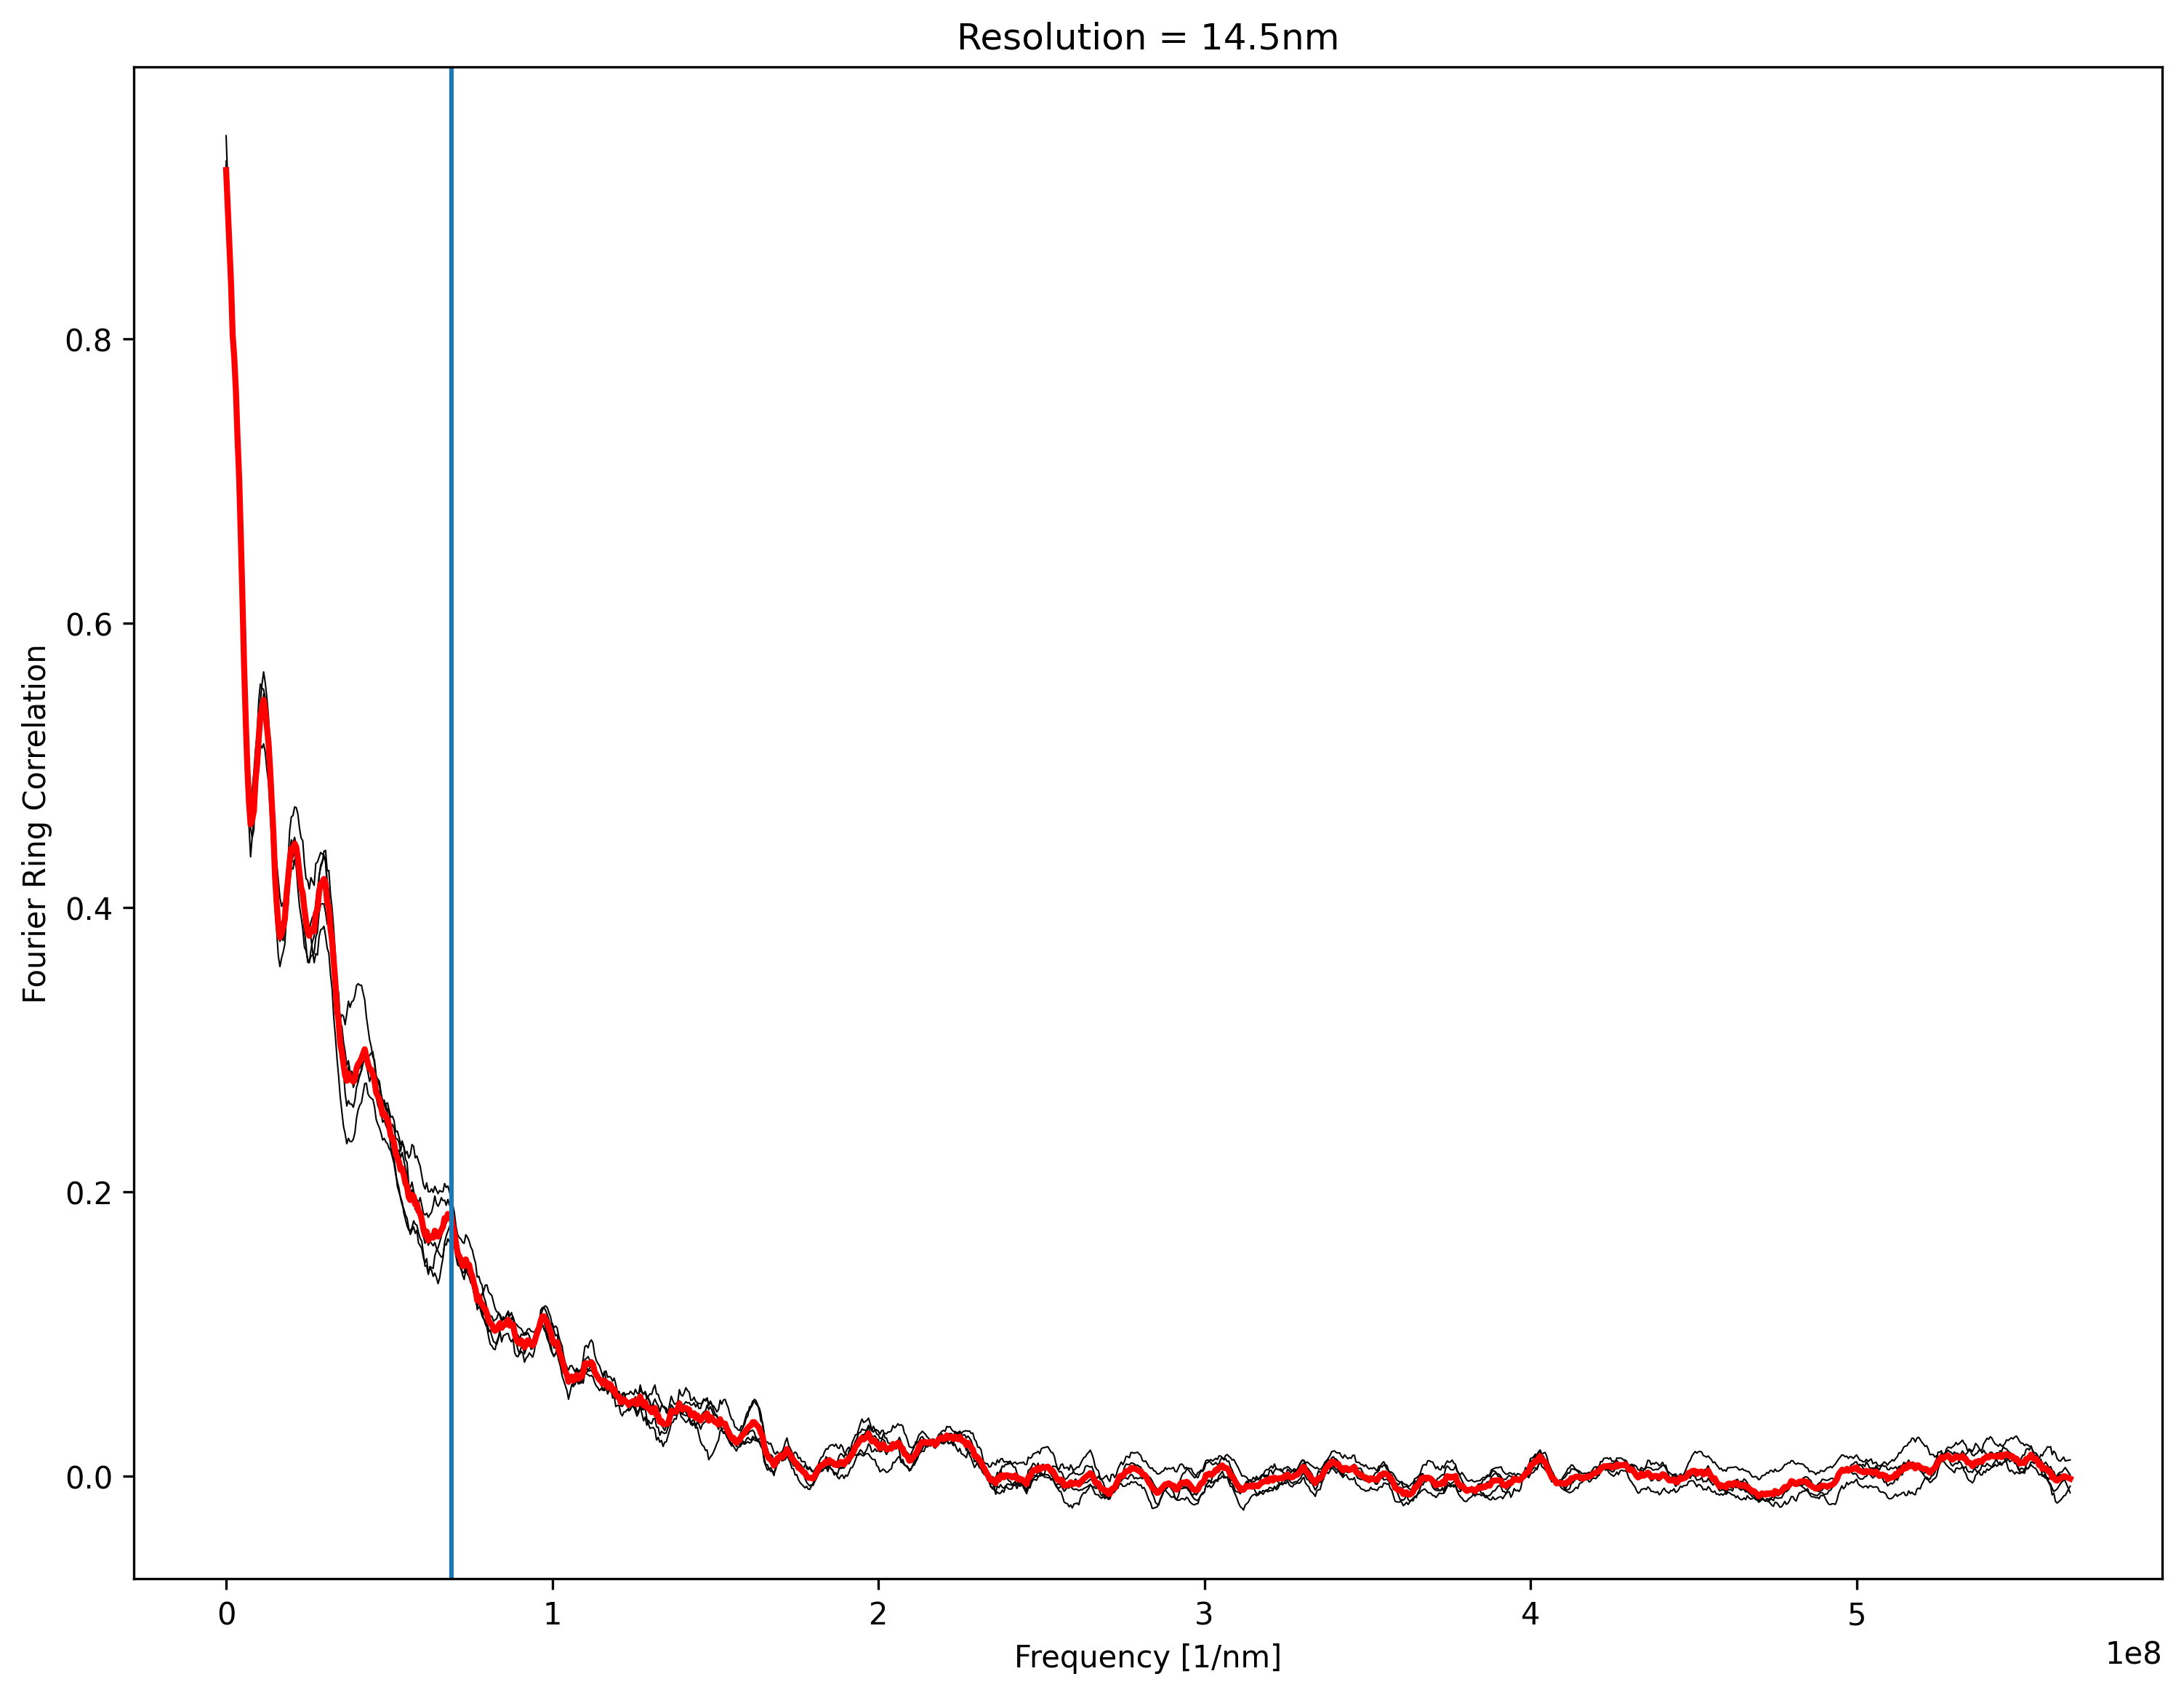

In [7]:
# Plot results
fig, ax = plt.subplots(1, 1, figsize=(12, 9), dpi=300)

# Plot individual cis in black and width = 0.75
for i in range(cis.shape[1]):
    ax.plot(qi, cis[:, i], 'k-', linewidth=0.5)
ax.plot(qi, ci, 'r-', linewidth=2)
ax.axvline(x=1.0 / resolution)
ax.set_xlabel("Frequency [1/nm]")
ax.set_ylabel("Fourier Ring Correlation")
ax.set_title(f"Resolution = {1e9 * resolution:.1f}nm");

### Simulate resolution progression throughout acquisition

In [8]:
t_start = processor.filtered_dataframe["tim"].min()
t_end = processor.filtered_dataframe["tim"].max()
t_steps = np.linspace(t_start, t_end, 11)
t_steps = t_steps[1:]

In [9]:
rx = (processor.filtered_dataframe["x"].min(), processor.filtered_dataframe["x"].max())
ry = (processor.filtered_dataframe["y"].min(), processor.filtered_dataframe["y"].max())

#### Using all localizations

In [10]:
resolutions = []
for i, t in enumerate(t_steps):
    df = processor.select_by_1d_range("tim", x_range=(t_start, t))
    x = df["x"].values
    y = df["y"].values
    resolution, _, _ = estimate_resolution_by_frc(
        x=x, y=y, rx=rx, ry=ry, num_reps=5, seed=2023, return_all=False
    )
    resolutions.append(1e9 * resolution)
    print(f"{len(x)} localizations: {i + 1}/{len(t_steps)}")
print(f"Resolution for the whole dataset: {resolutions[-1]:.1f}nm")

2678 localizations: 1/10
4842 localizations: 2/10
6798 localizations: 3/10
8332 localizations: 4/10
9678 localizations: 5/10
10543 localizations: 6/10
11053 localizations: 7/10
11480 localizations: 8/10
11661 localizations: 9/10
11902 localizations: 10/10
Resolution for the whole dataset: 6.9nm


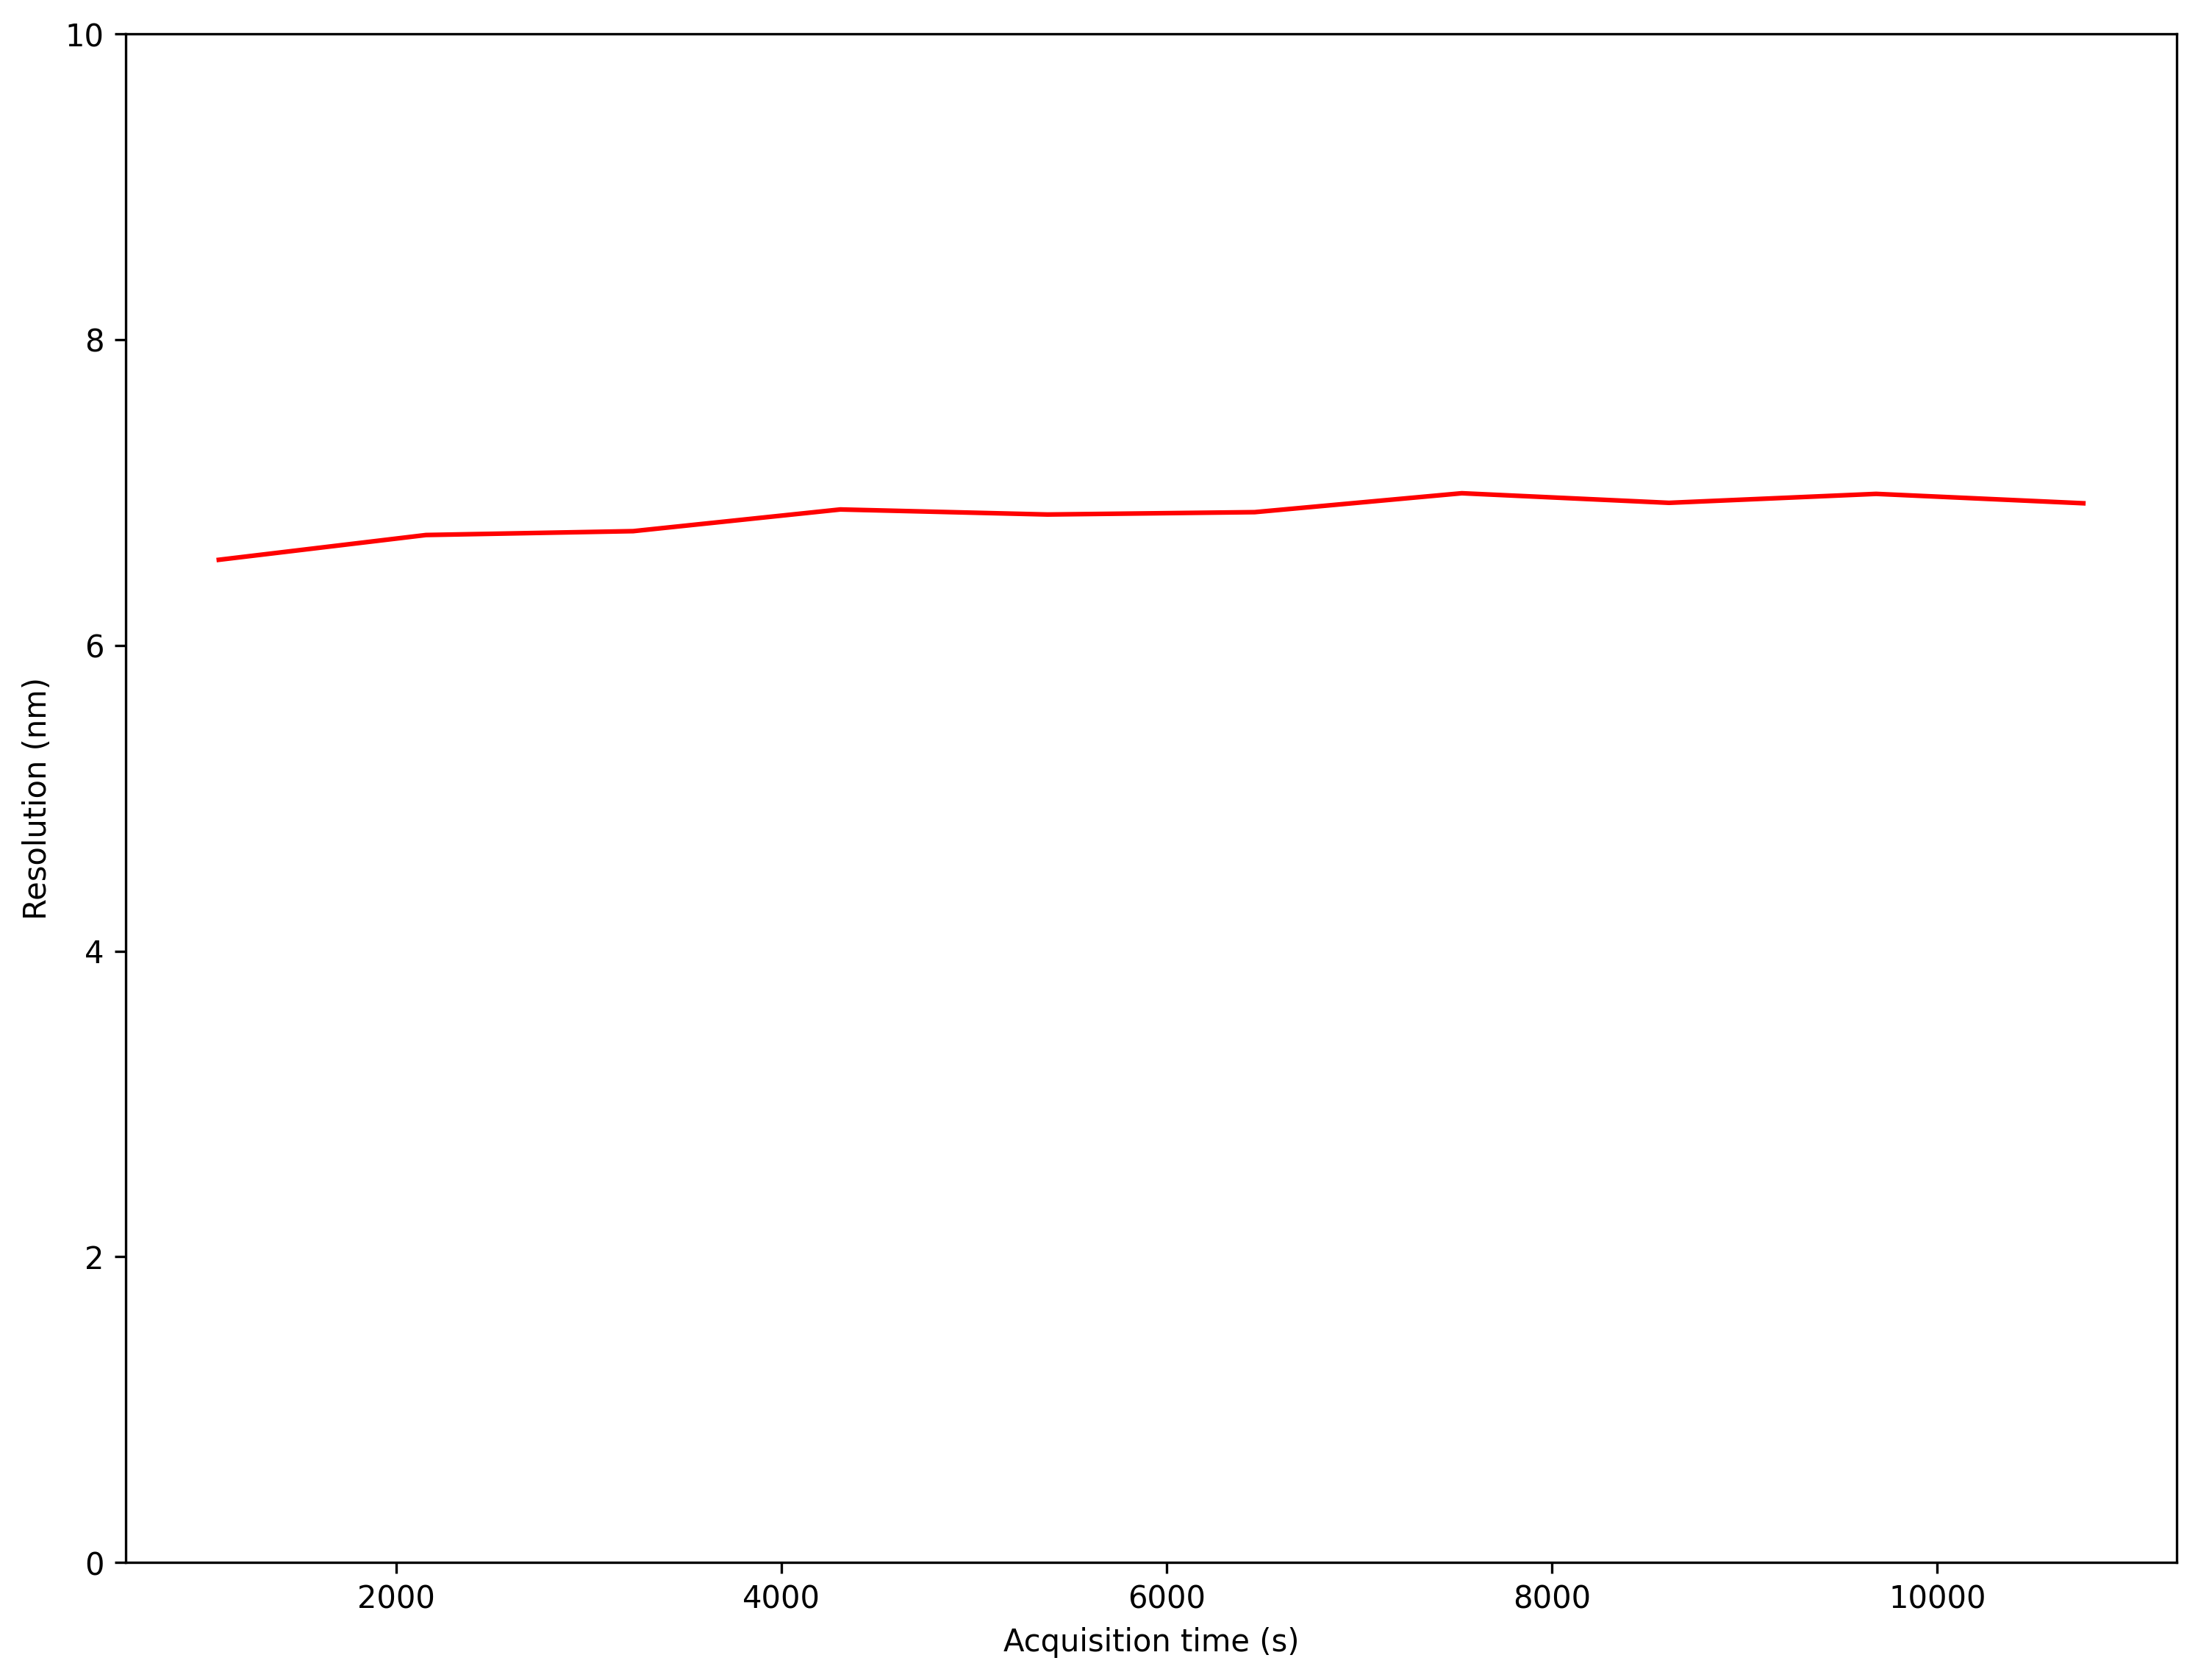

In [11]:
# Plot results
fig, ax = plt.subplots(1, 1, figsize=(12, 9), dpi=300)
ax.plot(t_steps, resolutions, 'r-')
ax.set_xlabel("Acquisition time (s)")
ax.set_ylabel("Resolution (nm)");
ax.set_ylim([0.0, 10.0]);

#### Using per-trace (average) localizations

In [12]:
trace_resolutions = []
for i, t in enumerate(t_steps):
    df = processor.select_by_1d_range("tim", x_range=(t_start, t))
    df_gr = df.groupby("tid")
    mx = df_gr["x"].mean()
    my = df_gr["y"].mean()
    resolution, _, _ = estimate_resolution_by_frc(
        x=mx, y=my, rx=rx, ry=ry, num_reps=5, seed=2023, return_all=False
    )
    trace_resolutions.append(1e9 * resolution)
    print(f"{len(mx)} traces: {i + 1}/{len(t_steps)}")

139 traces: 1/10
305 traces: 2/10
456 traces: 3/10
576 traces: 4/10
677 traces: 5/10
756 traces: 6/10
801 traces: 7/10
829 traces: 8/10
846 traces: 9/10
859 traces: 10/10


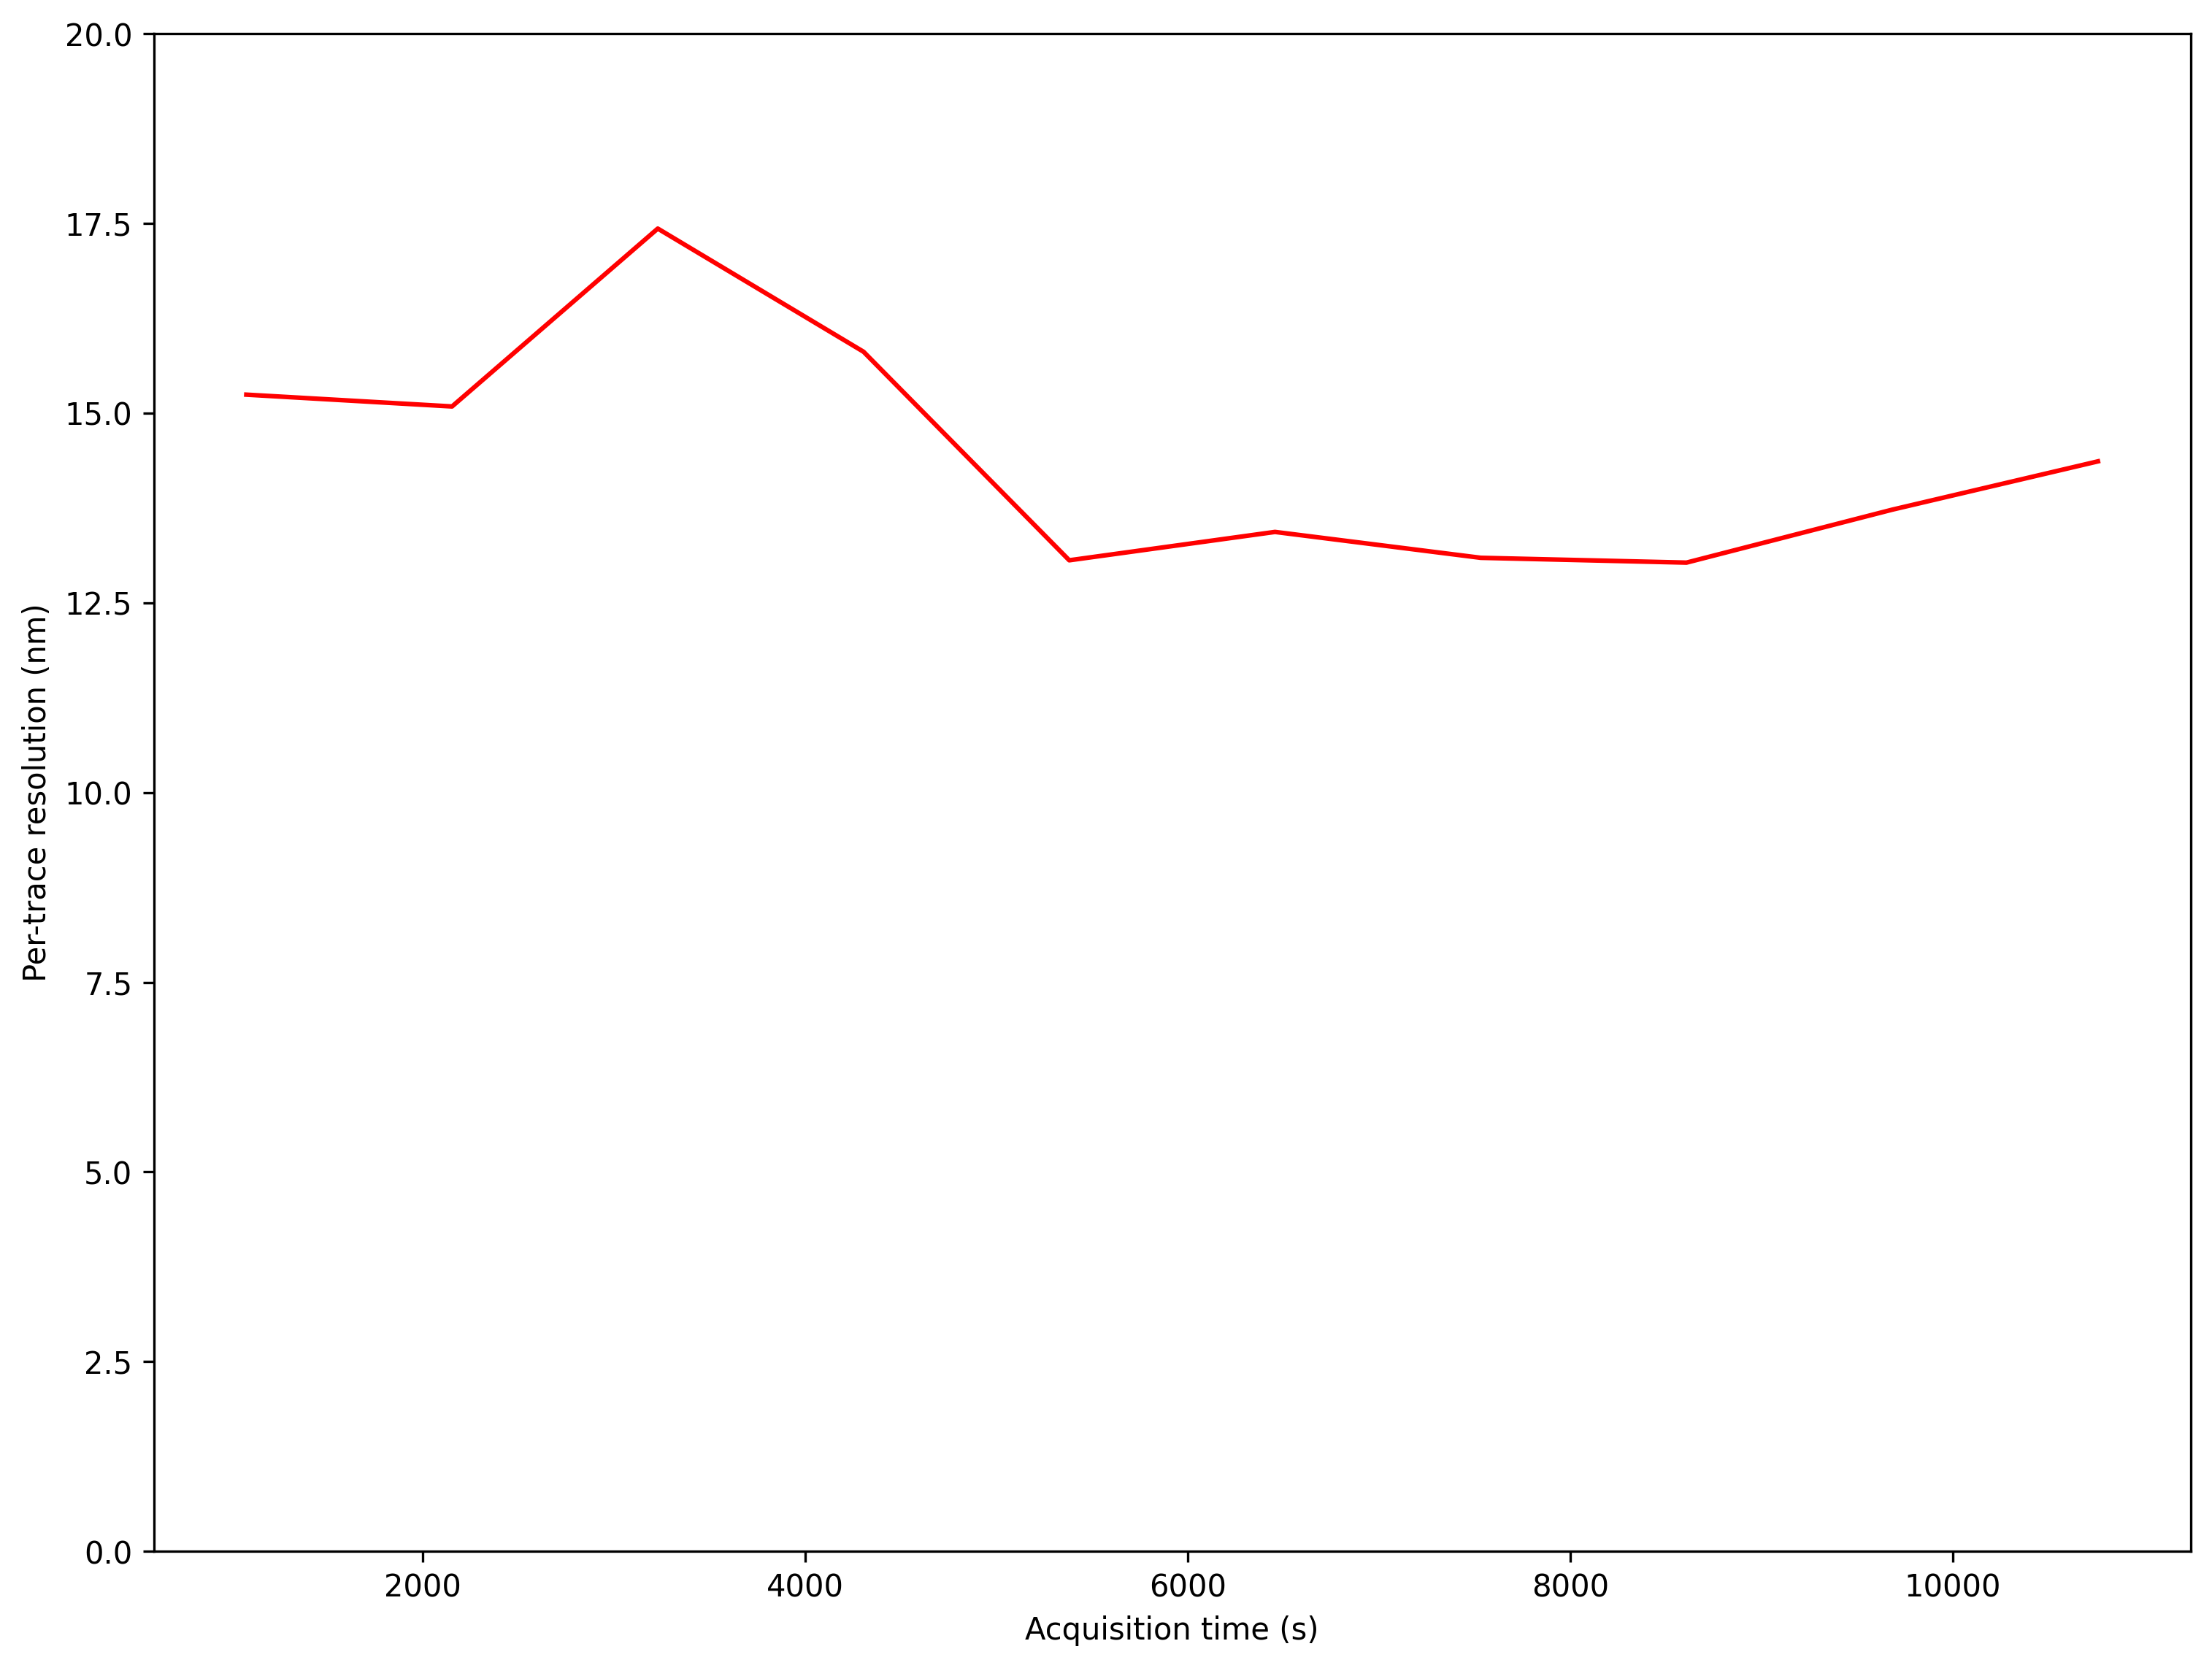

In [13]:
# Plot results
fig, ax = plt.subplots(1, 1, figsize=(12, 9), dpi=300)
ax.plot(t_steps, trace_resolutions, 'r-')
ax.set_xlabel("Acquisition time (s)")
ax.set_ylabel("Per-trace resolution (nm)")
ax.set_ylim([0.0, 20.0]);

## Apply EFO and CFR filters

In [14]:
# Apply EFO filter (limits already estimated from the UI)
processor.filter_by_1d_range("efo", x_range=(0, 49000))
processor.filter_by_1d_range("cfr", x_range=(0, 0.59))

In [15]:
# Re-calculate resolution
resolution, _, _ = estimate_resolution_by_frc(
    x=processor.filtered_dataframe_stats["mx"].values,
    y=processor.filtered_dataframe_stats["my"].values,
    rx=rx, ry=ry, num_reps=5, seed=2023, return_all=False
)

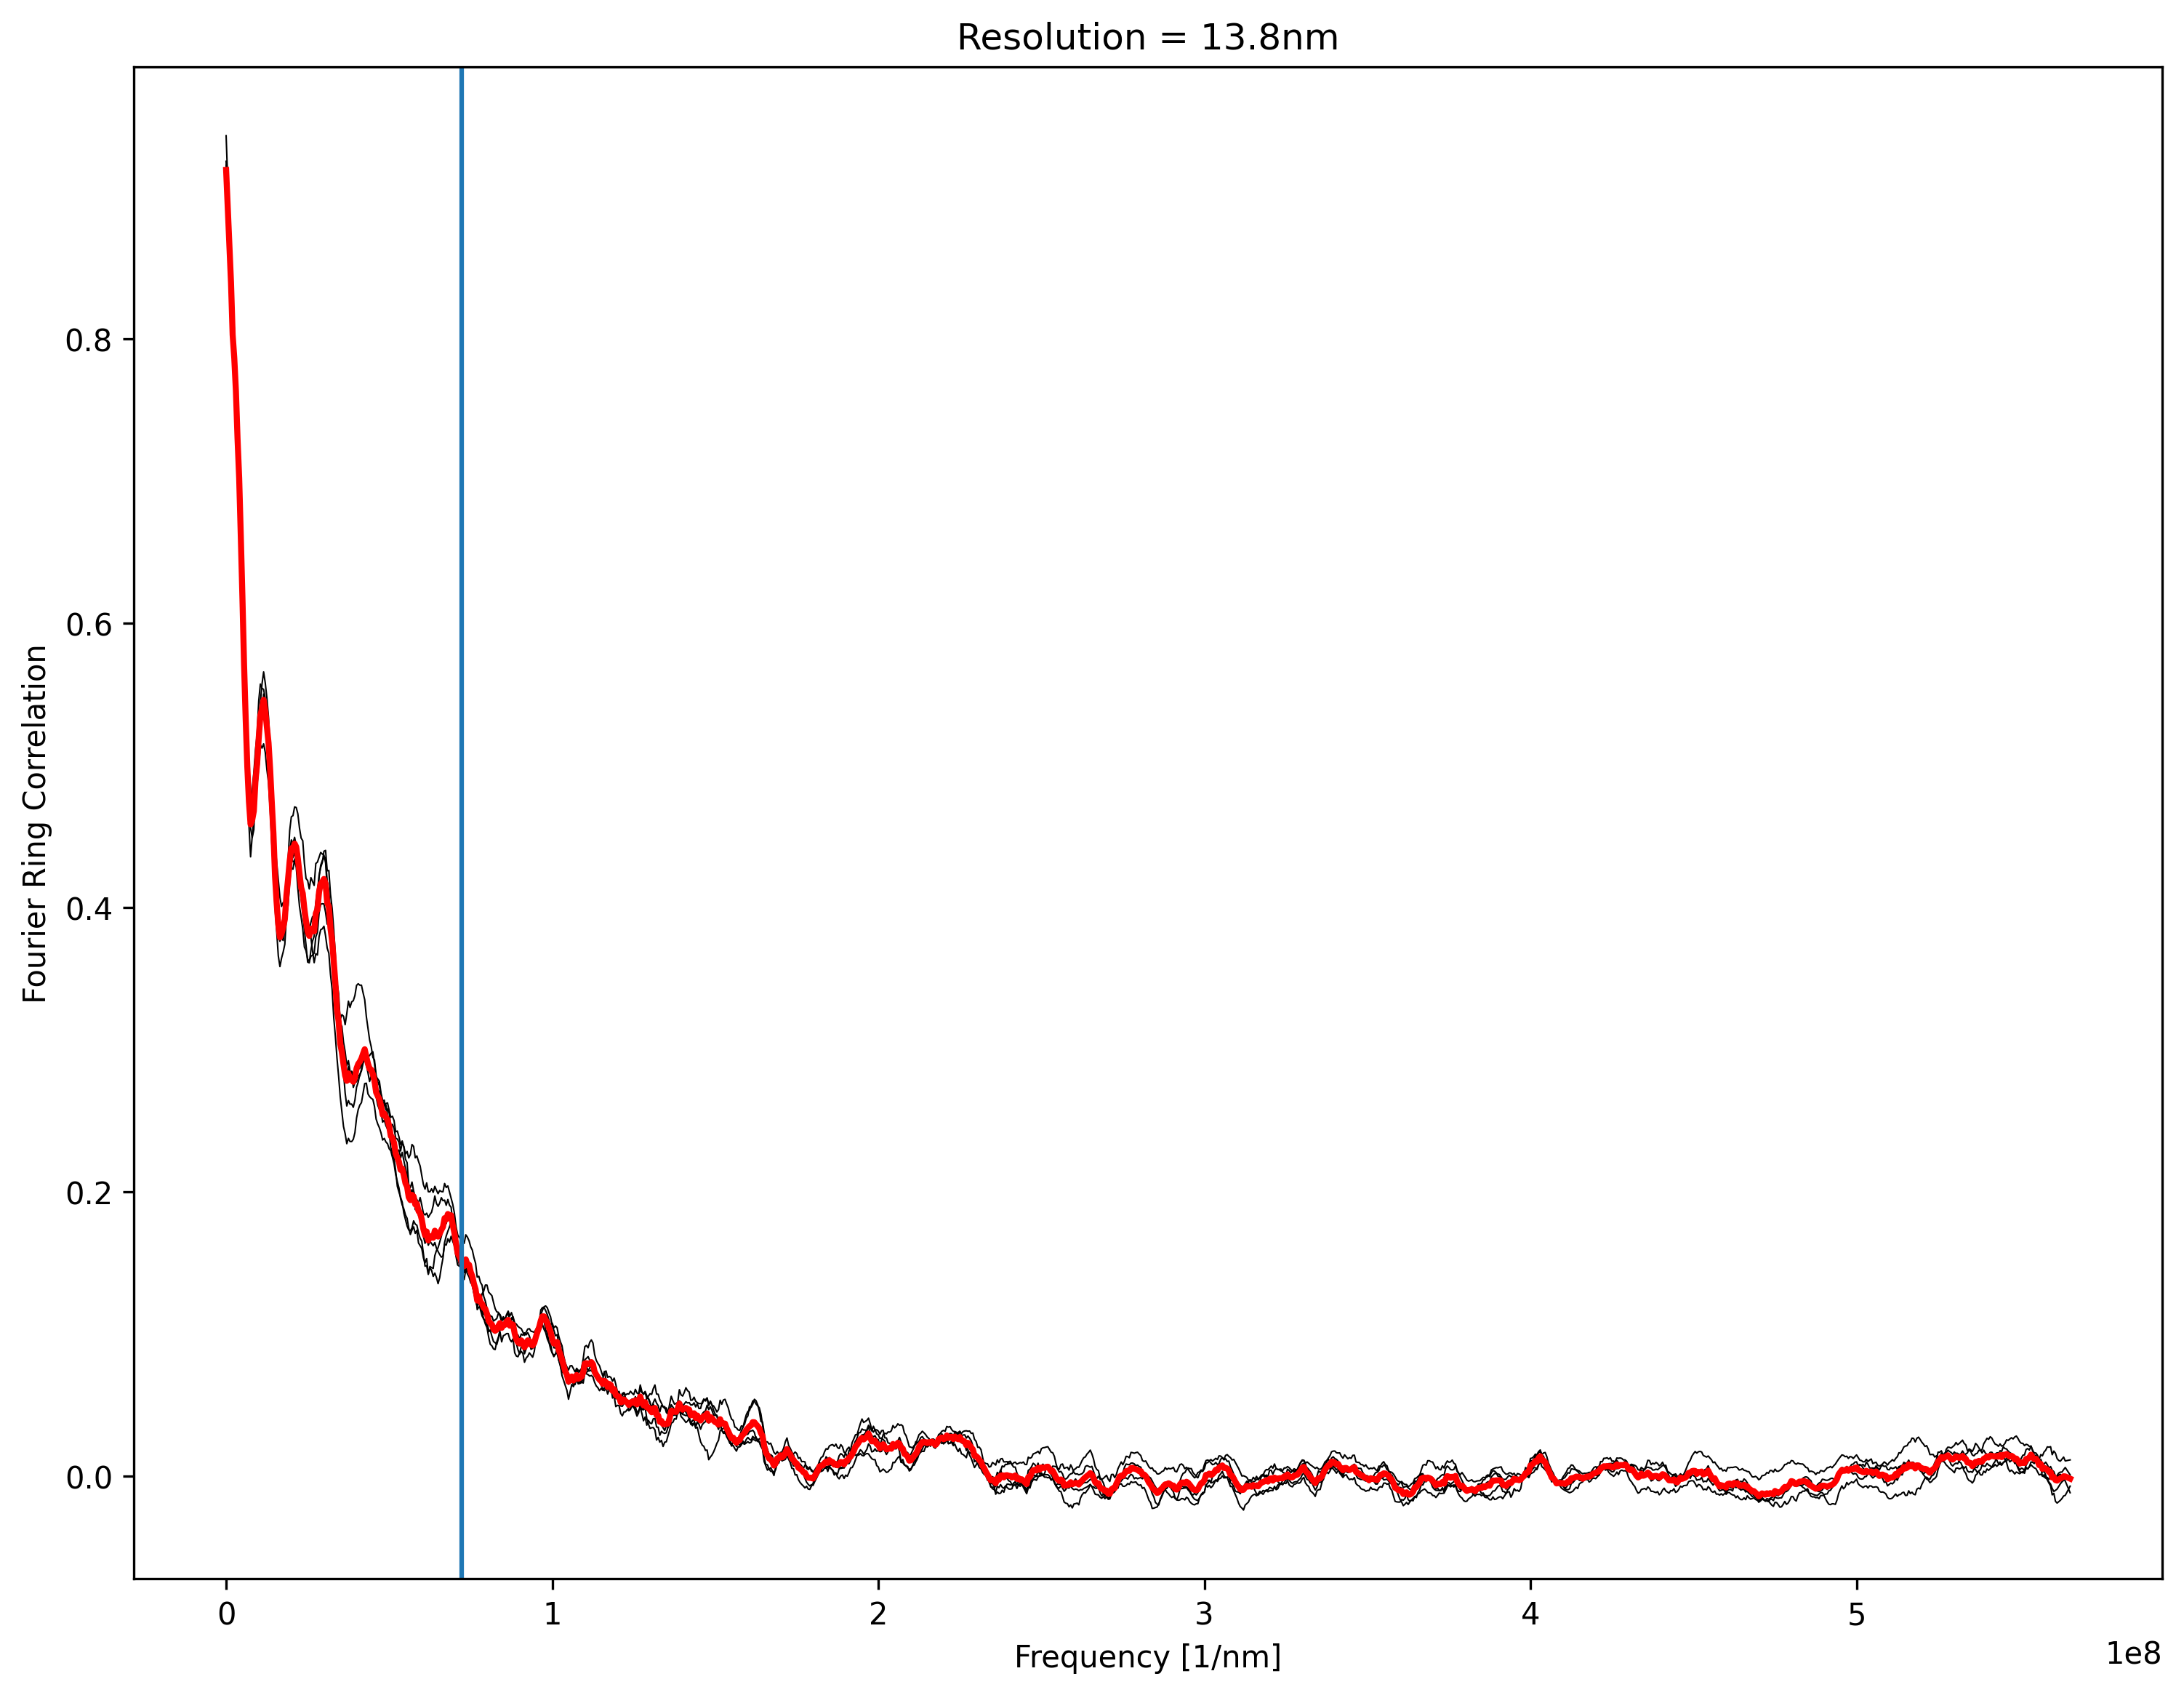

In [16]:
# Plot results
fig, ax = plt.subplots(1, 1, figsize=(12, 9), dpi=300)

# Plot individual cis in black and width = 0.75
for i in range(cis.shape[1]):
    ax.plot(qi, cis[:, i], 'k-', linewidth=0.5)
ax.plot(qi, ci, 'r-', linewidth=2)
ax.axvline(x=1.0 / resolution)
ax.set_xlabel("Frequency [1/nm]")
ax.set_ylabel("Fourier Ring Correlation")
ax.set_title(f"Resolution = {1e9 * resolution:.1f}nm");

## Apply drift correction

In [17]:
# Number of localization and time range (`min_trace_length` applies)
processor.num_values

9583

In [18]:
time_range = processor.filtered_dataframe["tim"].max() - processor.filtered_dataframe["tim"].min()
time_range

10755.720781175

In [19]:
# Set a time range so that we have a few windows for estimating the drift
T = 1200

In [20]:
# Estimate 2D drift
dx, dy, dxt, dyt, ti, T = drift_correction_time_windows_2d(
    x=processor.filtered_dataframe["x"],
    y=processor.filtered_dataframe["y"],
    t=processor.filtered_dataframe["tim"],
    sxy=2.0,
    T=T
)

In [21]:
# Plot the drift
x_c = processor.filtered_dataframe["x"] + dx
y_c = processor.filtered_dataframe["y"] + dy

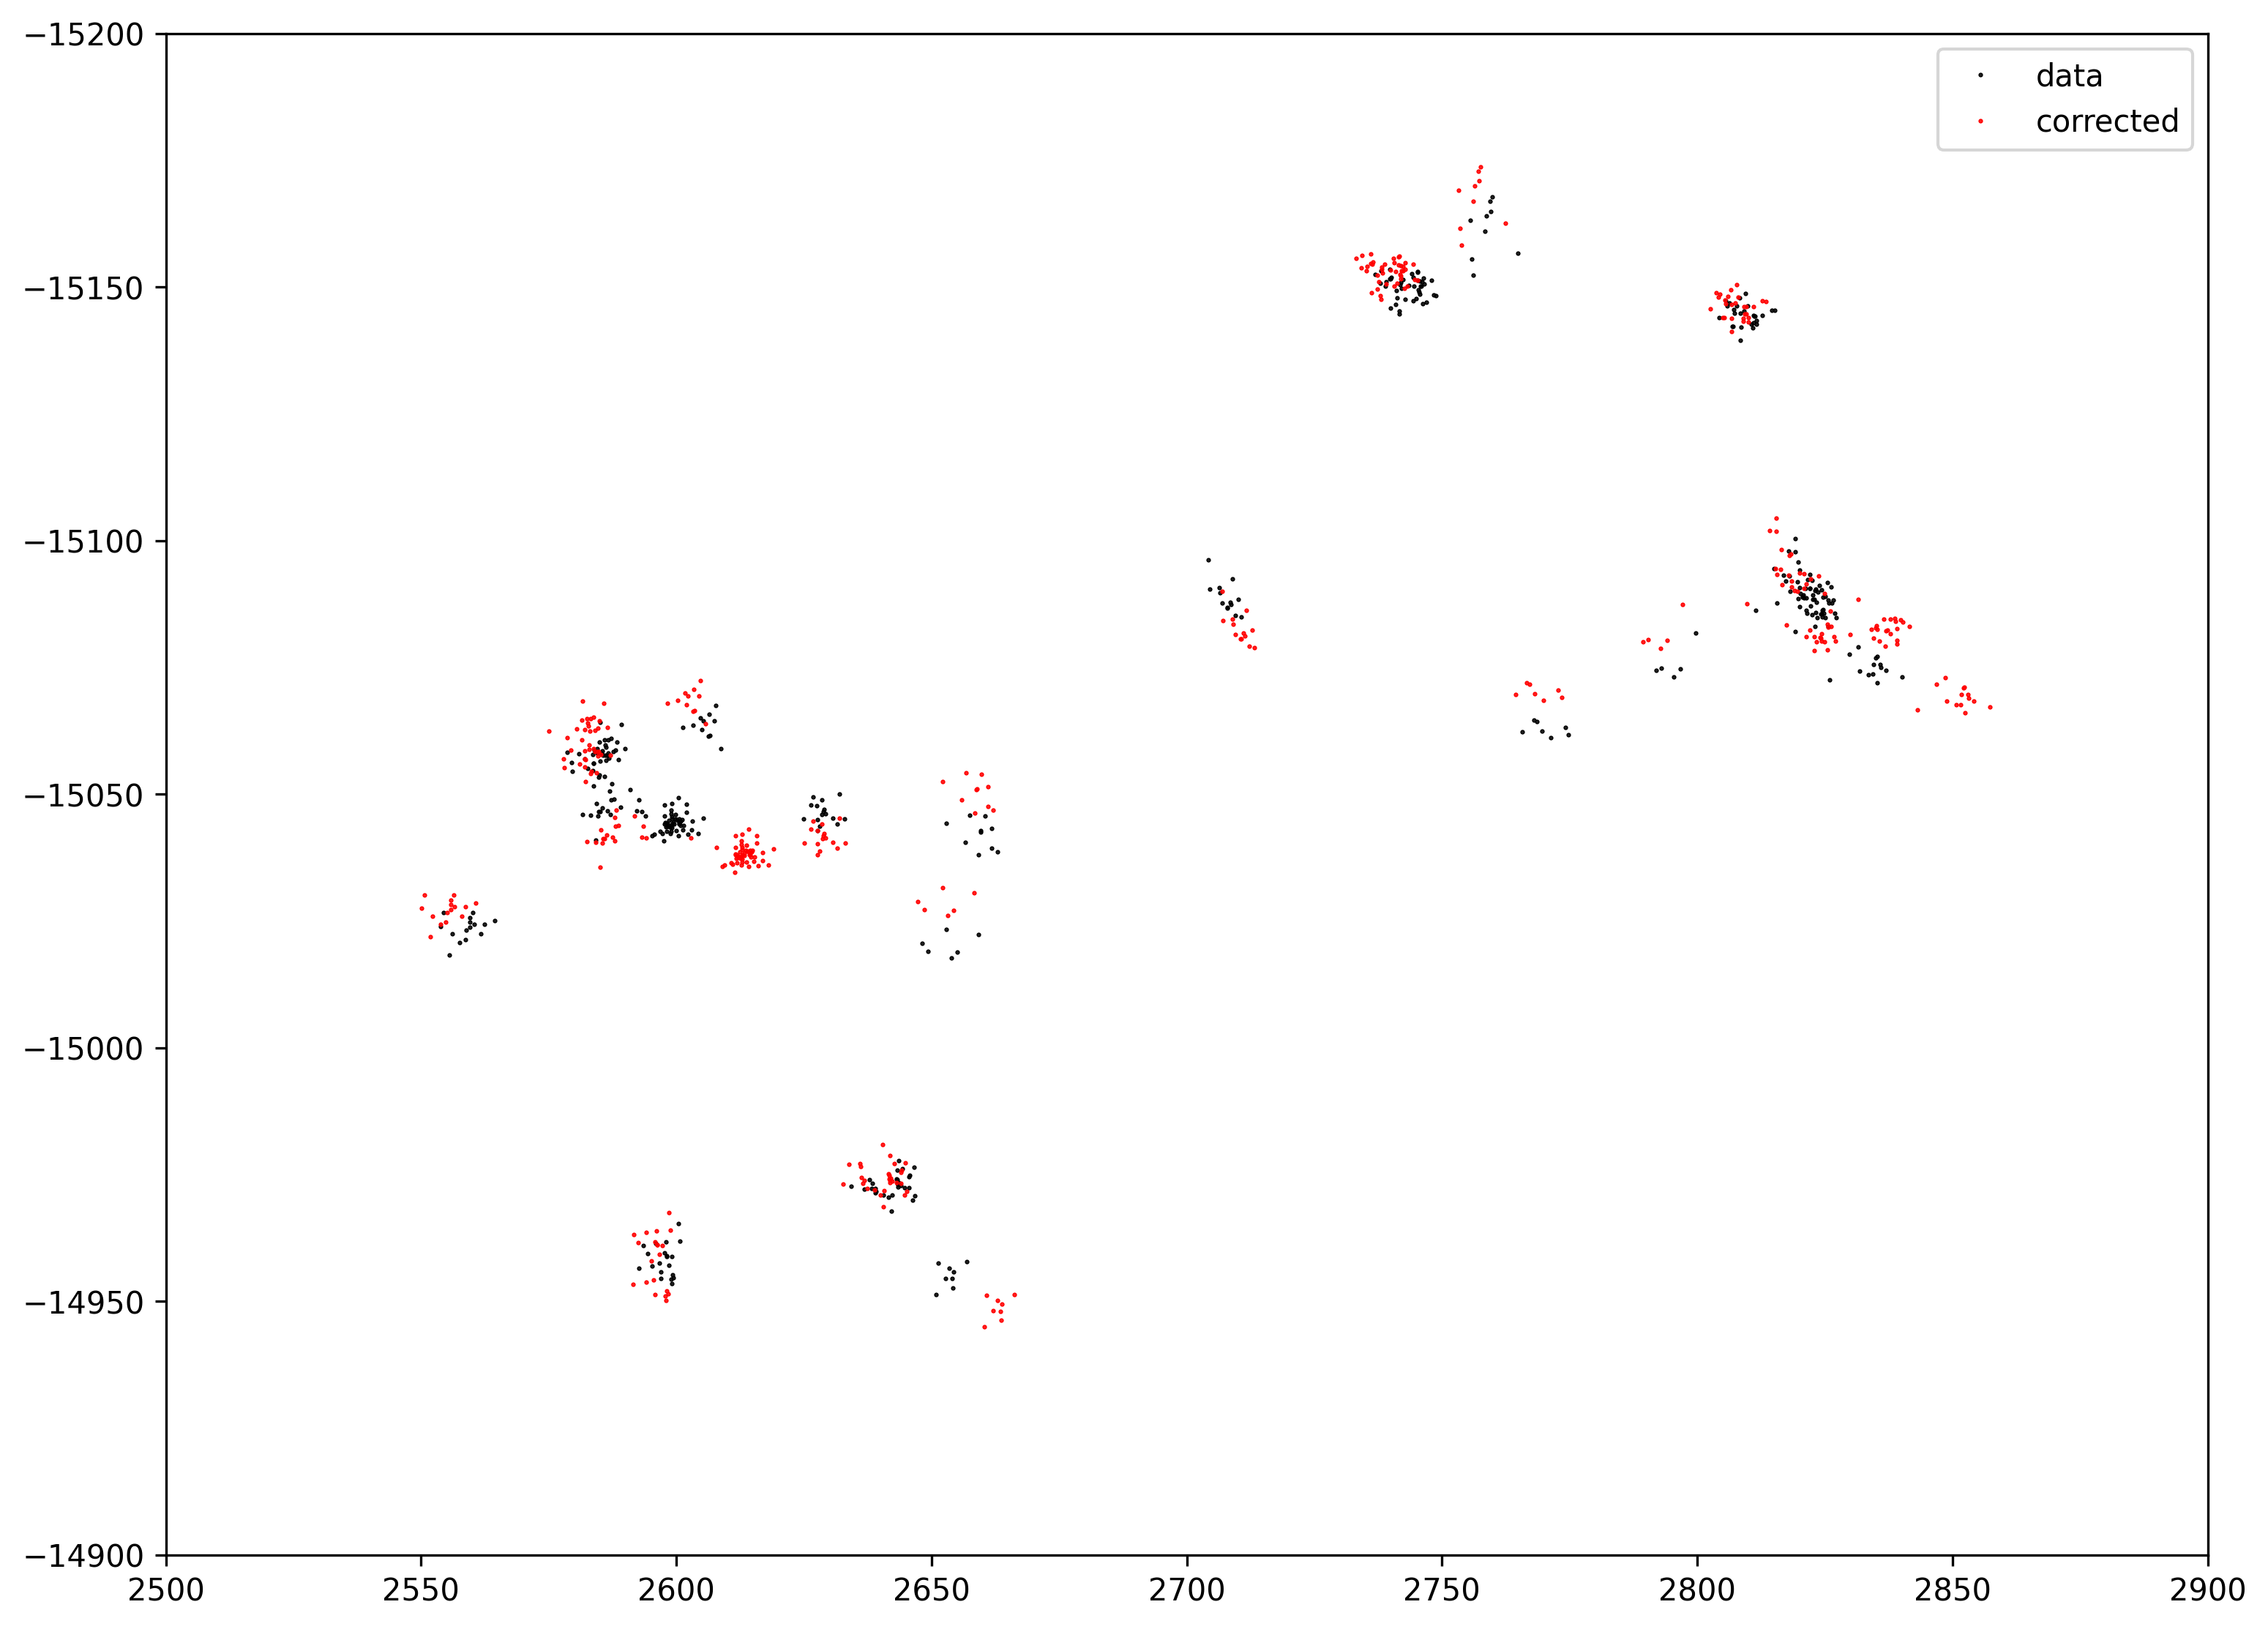

In [22]:
# Plot an inset
fig, ax = plt.subplots(1, 1, figsize=(12, 9), dpi=300)
ax.plot(processor.filtered_dataframe["x"], processor.filtered_dataframe["y"], 'k.', markersize=1, label="data")
ax.plot(x_c, y_c, 'r.', markersize=1, label="corrected")
ax.set_xlim([2500, 2900])
ax.set_ylim([-14900, -15200])
plt.legend();

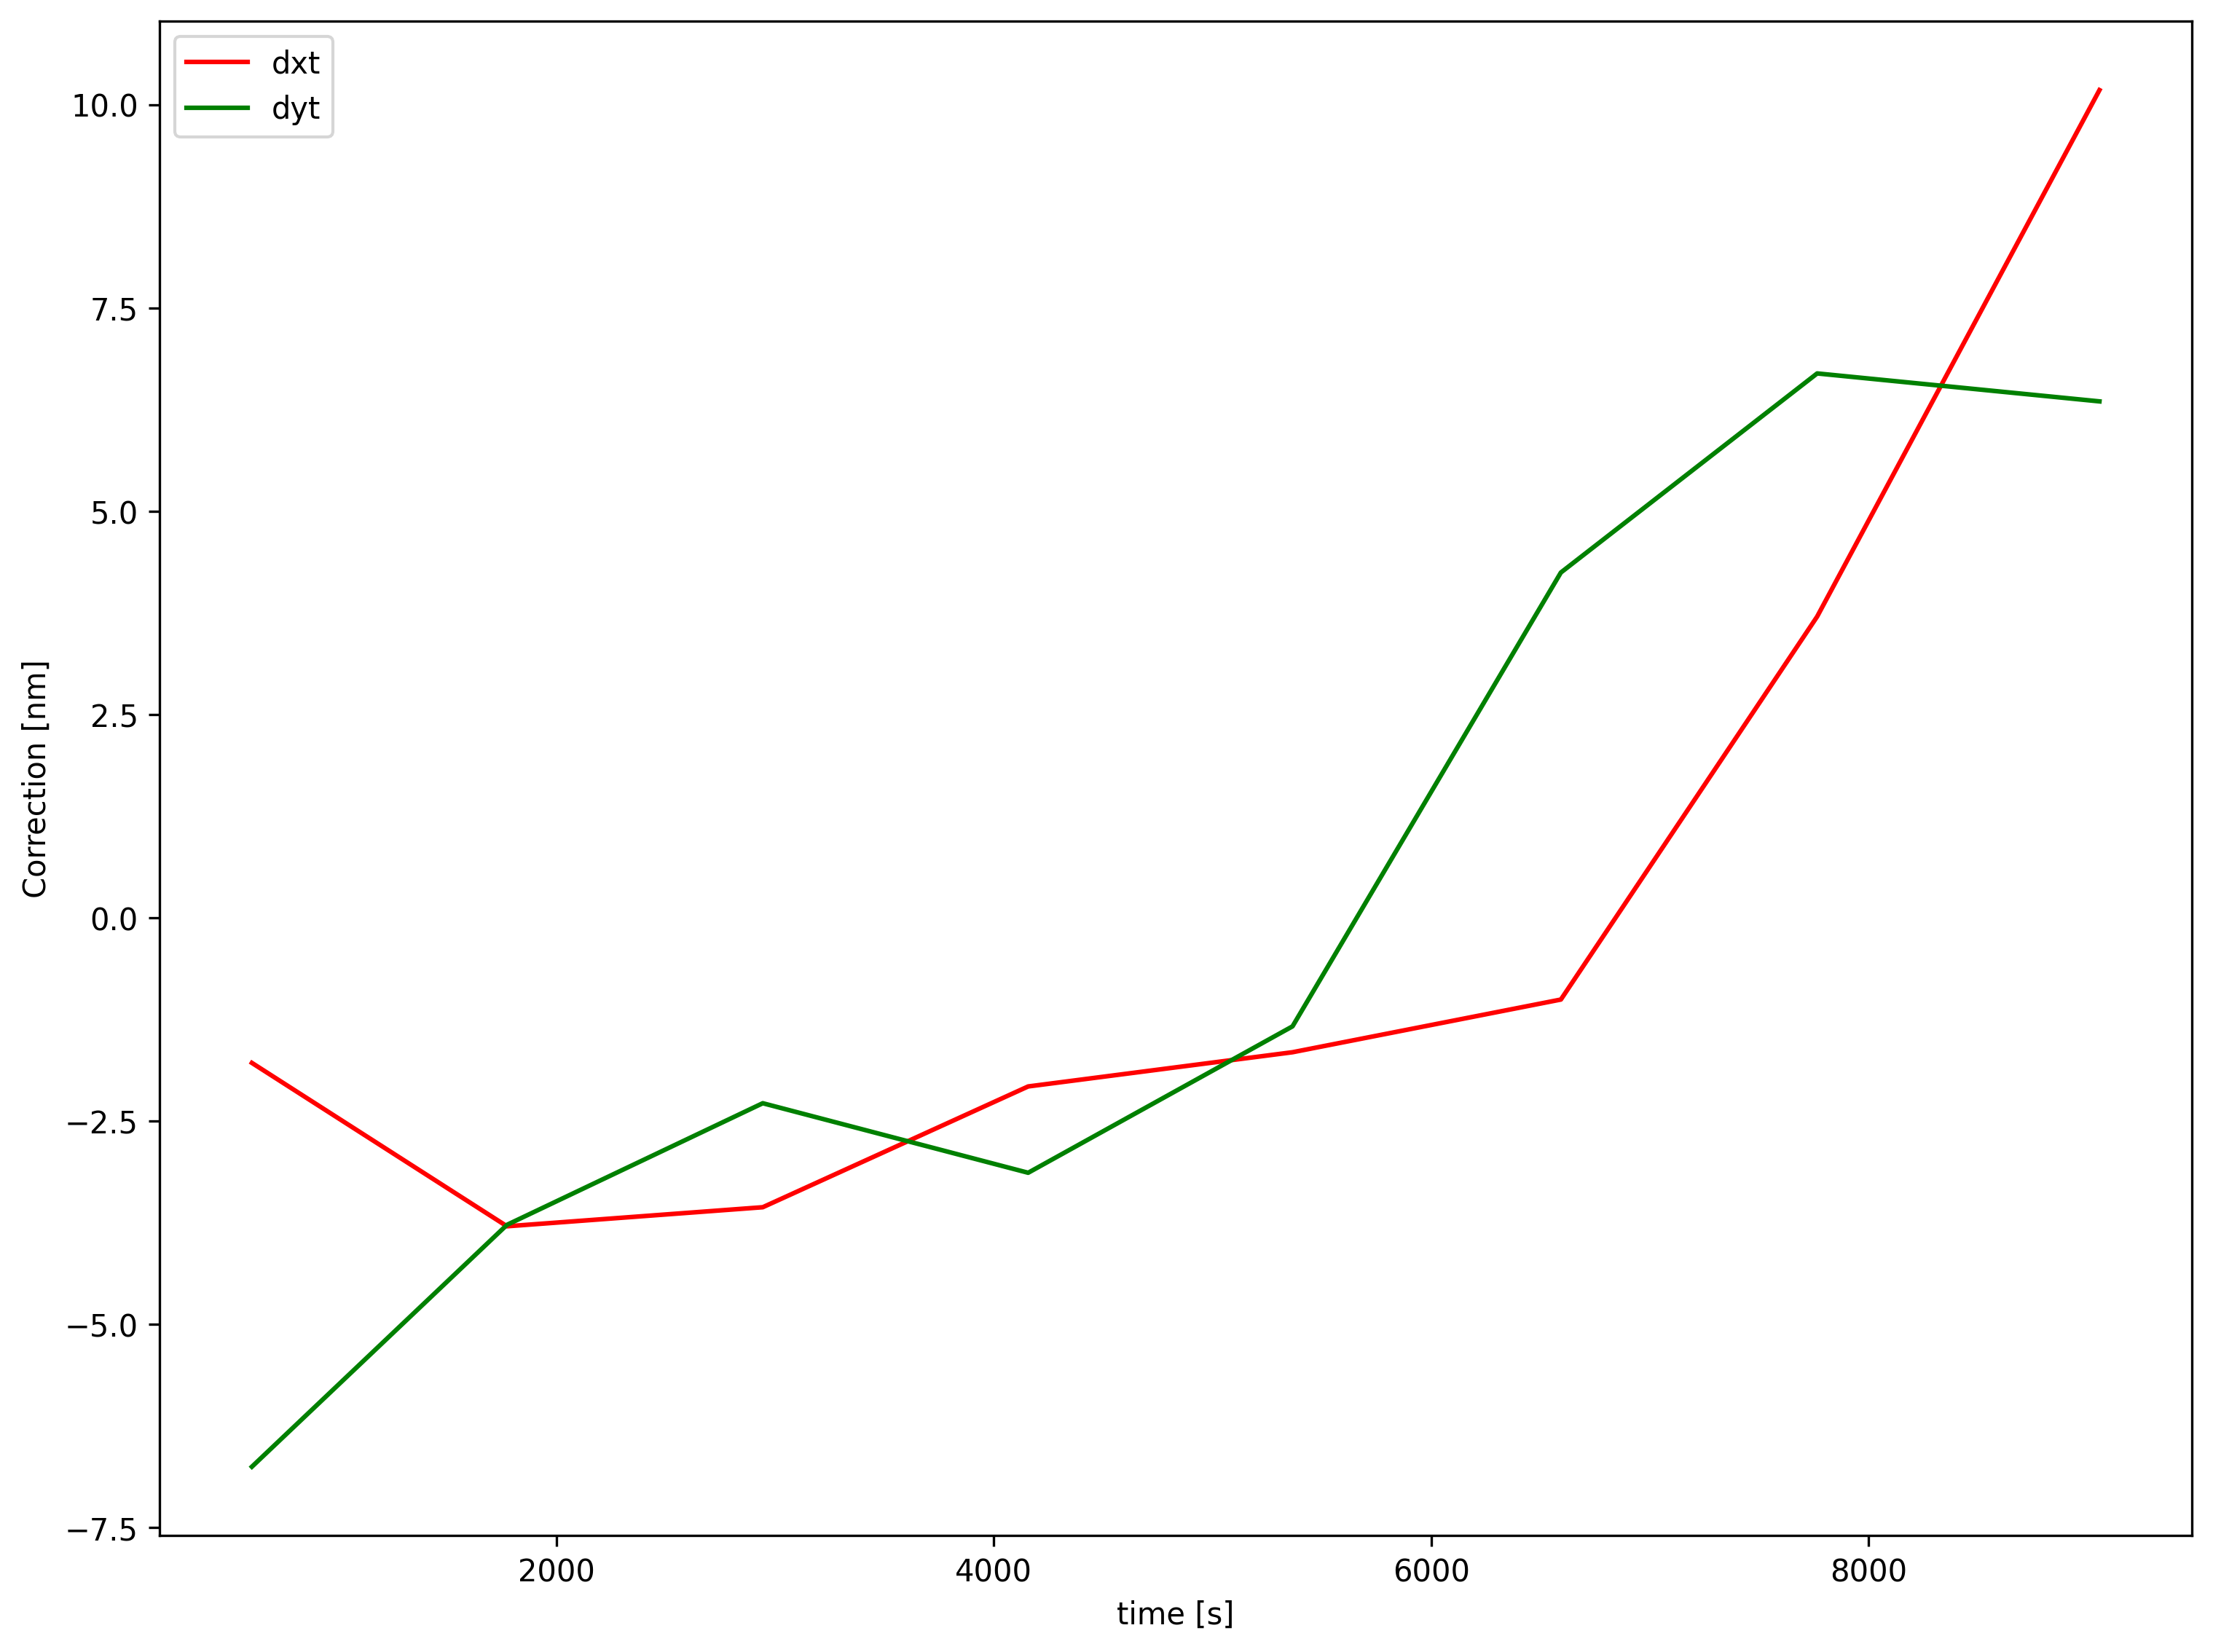

In [23]:
# Plot the (rough) correction
fig, ax = plt.subplots(1, 1, figsize=(12, 9), dpi=300)
ax.plot(ti, dxt, 'r-', label="dxt")
ax.plot(ti, dyt, 'g-', label="dyt")
ax.set_xlabel("time [s]")
ax.set_ylabel("Correction [nm]")
ax.legend();

### Drift-corrected data

In [24]:
# Store the drift-corrected localizations
processor.update_localizations(x_c, y_c)

In [25]:
# Run the resolution estimation on the drift-corrected data
resolution, qi, ci, resolutions, cis = estimate_resolution_by_frc(
    x=processor.filtered_dataframe_stats["mx"].values,
    y=processor.filtered_dataframe_stats["my"].values,
    rx=None, ry=None, num_reps=5, seed=2023, return_all=True
)

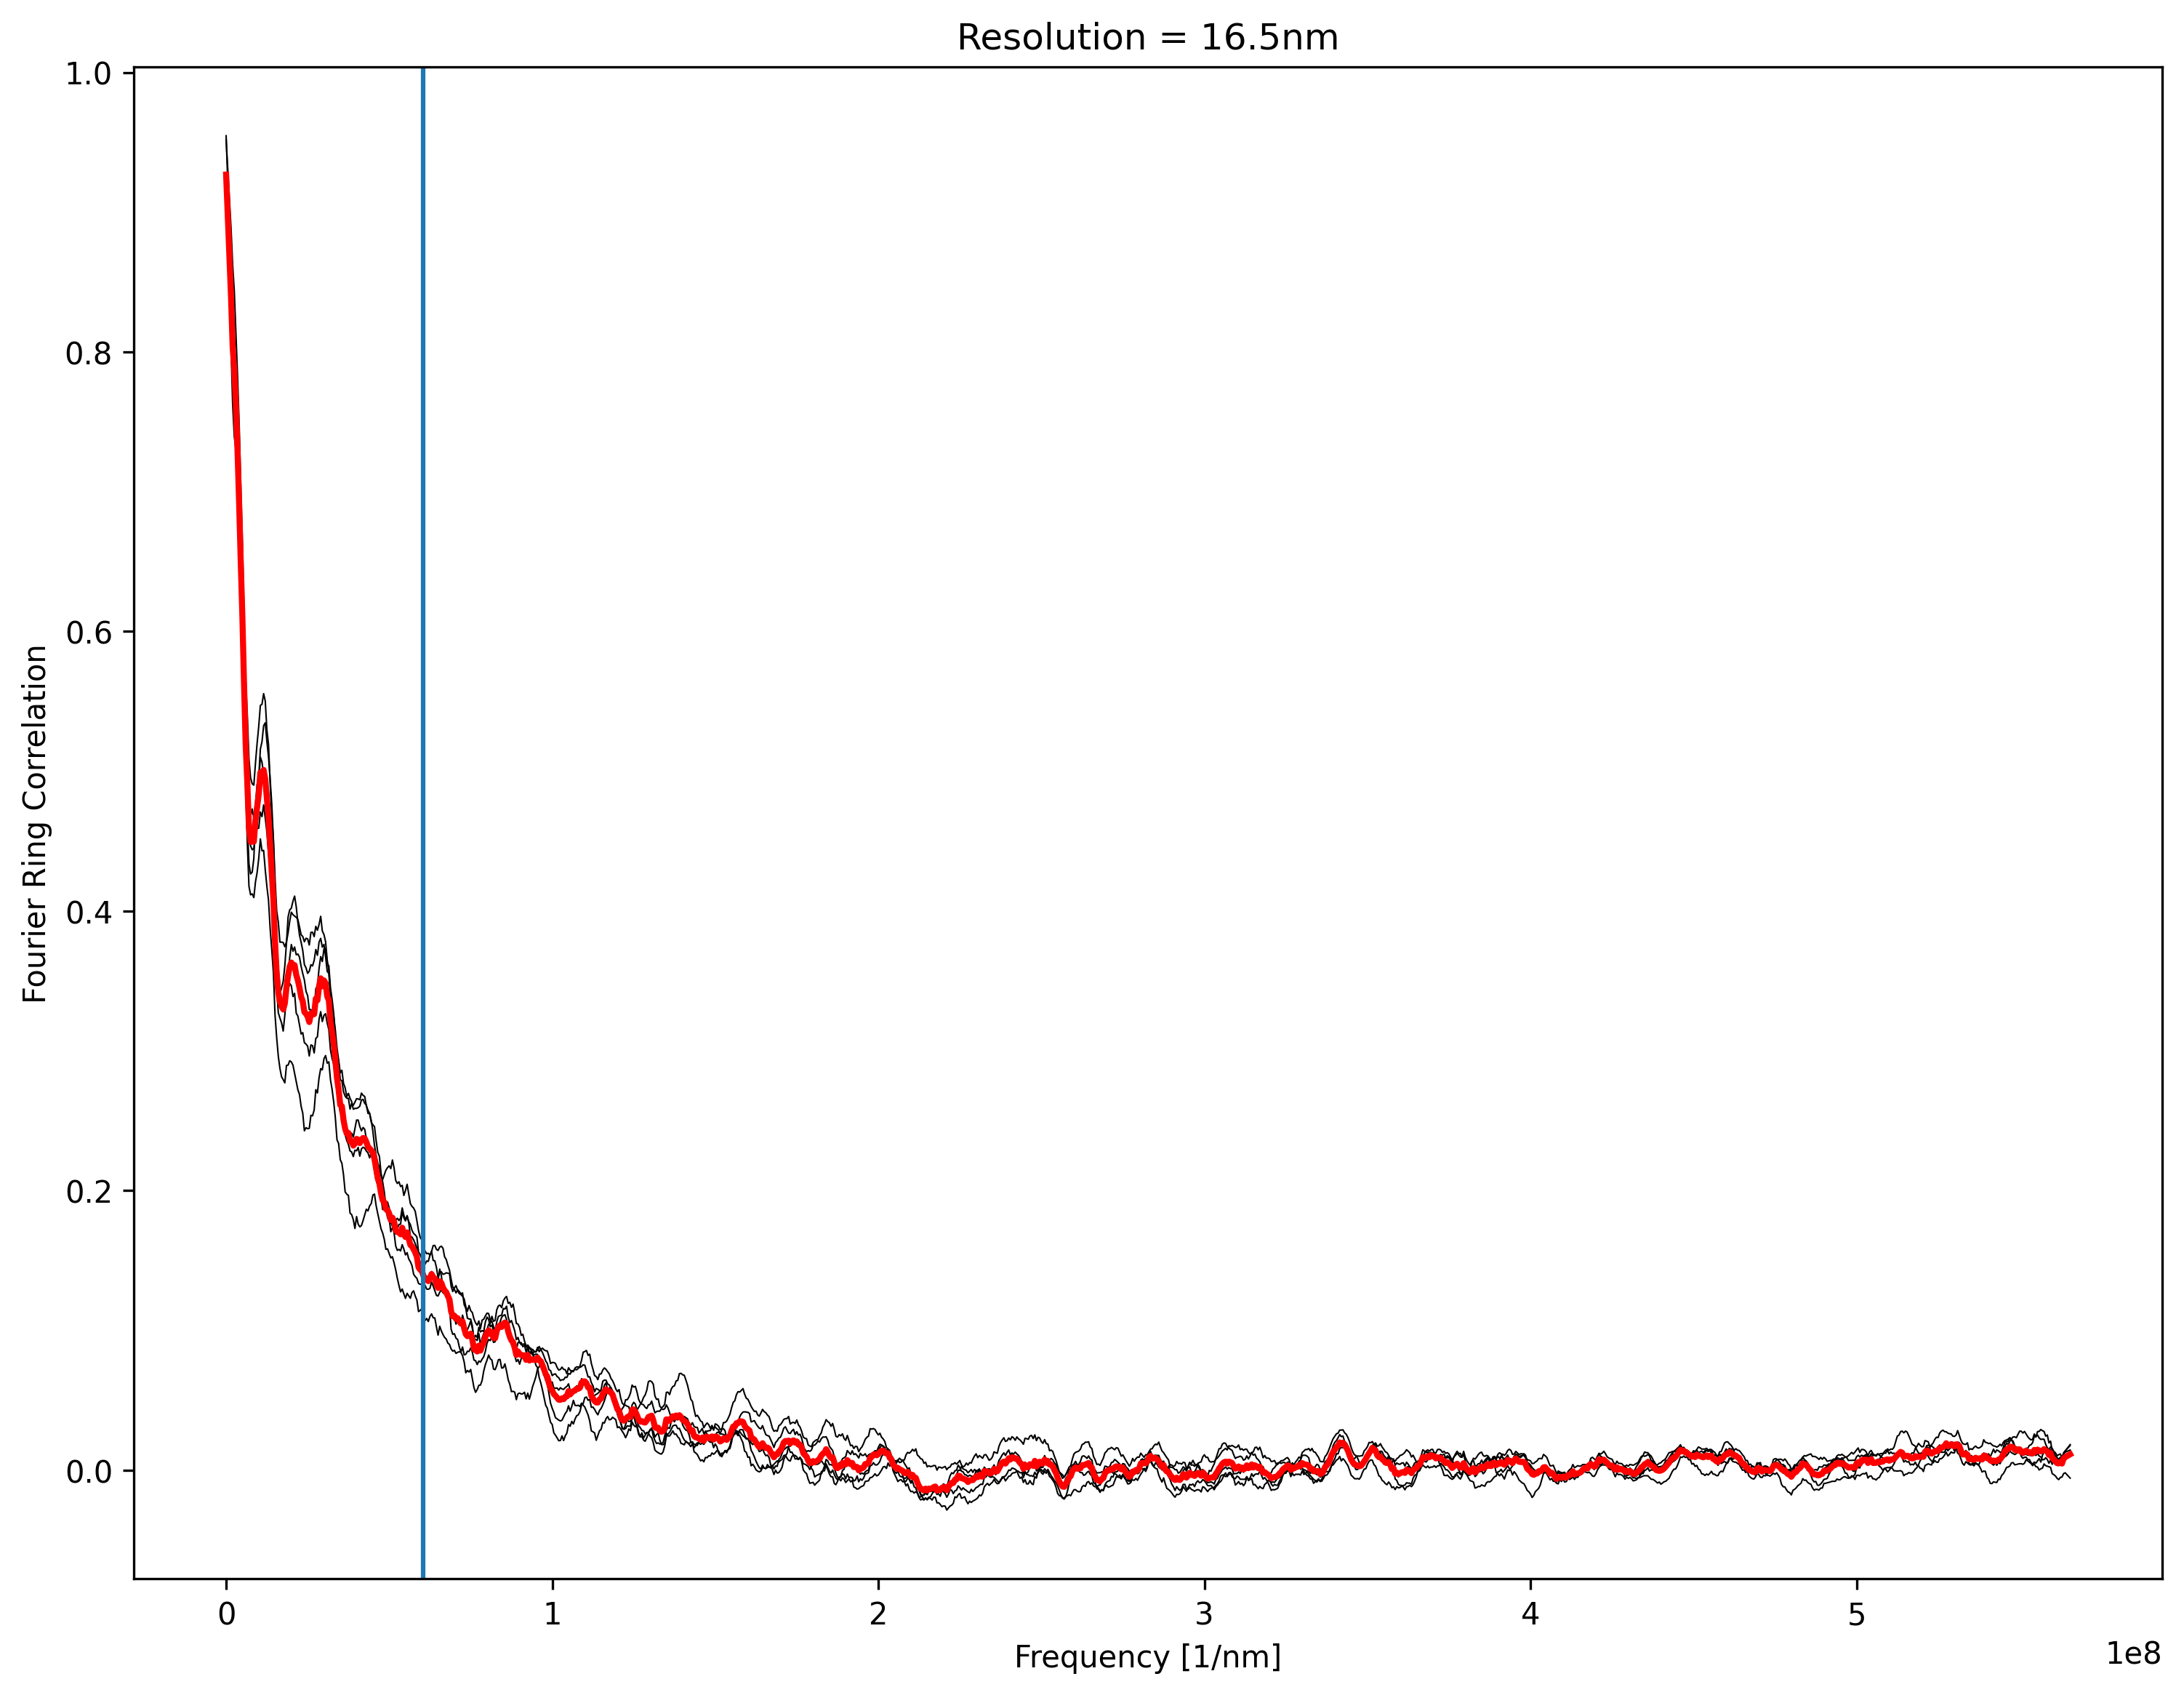

In [26]:
# Plot results
fig, ax = plt.subplots(1, 1, figsize=(12, 9), dpi=300)

# Plot individual cis in black and width = 0.75
for i in range(cis.shape[1]):
    ax.plot(qi, cis[:, i], 'k-', linewidth=0.5)
ax.plot(qi, ci, 'r-', linewidth=2)
ax.axvline(x=1.0 / resolution)
ax.set_xlabel("Frequency [1/nm]")
ax.set_ylabel("Fourier Ring Correlation")
ax.set_title(f"Resolution = {1e9 * resolution:.1f}nm");